In [1]:
import numpy as np
import openpyxl.utils


import torch
import pylab as plt
from munch import munchify
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from tqdm import tqdm
%matplotlib inline

In [2]:
# datafile to load the data. This cell and the next cell are just for having some sense of how to feed data.
# Please load your own data and make them similar to the shape of data in dataset.
project_root = 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification'
data_root = 'data'
test_setName= 'Exact_UVA_patches_400_100_100_maskedProstate_01-30-2022.mat'
data_file = '/'.join([project_root, data_root, test_setName])
print('loading data...')
input_data = load_matlab(data_file)
print('loading done!')

num_workers = 0
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

input_data = dataset.preprocess(input_data, norm='mean0var1', shffl_patients=False, signal_split=False,
                        split_rs=26, val_size=0.25, augment=False)

loading data...
loading done!


C:\Users\Mahdi\Desktop\Summer21\RA\Codes\Minh_Mahdi_mod\prostate_cancer_classification\utils\dataset.py:629: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  input_data[f'data_{set_name}'] = np.array(input_data[f'data_{set_name}'])


In [3]:
# This function takes in net, device, and pair of (input, label, location) and produces output
# This is used in the next cell
def drop_eval(net, x_raw, n_batch, T_samples):
    pred_list, unc_list = [], []
    for i in range(T_samples):
        out1 = net(x_raw, n_batch)
        pred = F.softmax(out1, dim=1)
        pred_list.append(torch.unsqueeze(pred, dim=0))
    pred_mean = torch.cat(pred_list, 0).mean(dim=0)
    confidence,_ = torch.max(pred_mean, dim=1)
    unc = 1. - confidence
    return pred_mean, unc

def predict(net, input_data, input_label, device, unc_method, T_samples=30, unc_thr=0.2):
    from sklearn.metrics import confusion_matrix


    # location is not important here, so we make it up randomly
    input_location = torch.ones_like(input_label)

    outputs = []
    entropic_scores = []
    uncertainty = []
    total = correct = 0

    cm = np.zeros((2,2))
    cm_unc = np.zeros((2,2))

    no_data = len(input_data)
    batch_size = 32
    no_batch = no_data//batch_size
    noPatch_unc = 0
    # print('no batches and batch size:', no_batch, batch_size)
    # built-in function of class torch.utils.Dataset which sets model in evaluation mode
    # (here both evaluation and training are the same)
    net.eval()
    # apply model on test signals
    with torch.no_grad():
        for i in range(no_batch+1):
            strt = i*batch_size
            end = (i+1)*batch_size
            x_raw, y_batch, n_batch = input_data[strt:end,...], input_label[strt:end,...], input_location[strt:end,...]
            x_raw, y_batch, n_batch = x_raw.to(device), y_batch.to(device), n_batch.to(device)

            if unc_method=='dropout':
                # pred and uncertainty (1-confidence) of dropout
                pred, unc = drop_eval(net, x_raw, n_batch, T_samples)
            elif unc_method=='edl':
                out1 = net(x_raw, n_batch)
                pred = F.softmax(out1, dim=1)

                alpha = F.relu(out1) + 1
                unc = 2. / torch.sum(alpha, dim=1, keepdim=True).reshape(-1)
            elif unc_method=='vanilla':
                out1 = net(x_raw, n_batch)
                pred = F.softmax(out1, dim=1)
                crnt, _ = torch.max(pred, dim=1)
                unc = 1-crnt

            probabilities = pred  # torch.nn.Softmax(dim=1)(pred)
            entropies = -(probabilities * torch.log(probabilities)).sum(dim=1)
            entropic_scores.append((-entropies).cpu().numpy())

            uncertainty.append(unc.cpu().numpy())

            outputs.append(pred.cpu().numpy())
            total += y_batch.size(0)
            correct += (pred.argmax(dim=1) == torch.argmax(y_batch, dim=1)).sum().item()

            cm += confusion_matrix(y_batch.argmax(dim=1).cpu(), pred.argmax(dim=1).cpu(), labels=[0,1])
            ind_unc = unc<=unc_thr
            noPatch_unc += torch.sum(ind_unc).item()
            cm_unc += confusion_matrix((y_batch[ind_unc, ...]).argmax(dim=1).cpu(),
                                       (pred[ind_unc, ...]).argmax(dim=1).cpu(), labels=[0,1])


    tn, fp, fn, tp = cm.ravel()
    tn_unc, fp_unc, fn_unc, tp_unc = cm_unc.ravel()
    acc_sb = (tp/(tp+fn) + tn/(tn+fp))/2.0
    acc_sb_unc = (tp_unc/(tp_unc+fn_unc) + tn_unc/(tn_unc+fp_unc))/2.0

    outputs = np.concatenate(outputs)
    uncertainty = np.concatenate(uncertainty)
    entropic_scores = np.concatenate(entropic_scores)
    return outputs, uncertainty, entropic_scores, correct / total, acc_sb, acc_sb_unc, noPatch_unc

def infer_core_wise2(predictions, uncertainty, core_len, roi_coors, unc_thr, ood_scores=None):
    """
    Infer core-wise predictions based on signal-wise predictions.
    Input must be 1-D array
    :param predictions: signal-wise predictions
    :param core_len: length of each core
    :param roi_coors: pixel-wise coordinates of ROI area
    :param ood_scores:
    :return:
    """
    counter = 0
    no_uncCores = 0
    core_feat1, core_res1, core_l1, core_l2, core_l3, core_ood = [], [], [], [], [], []
    prediction_maps = []
    core_unc =[]

    # find a label for each core
    for i in range(len(core_len)):
        temp = predictions[counter:(counter + core_len[i])]
        un = uncertainty[counter:(counter + core_len[i])]
        temp2 = temp[un <= unc_thr, ...]
        if len(temp2) <= np.round(0.6*core_len[i]):
            no_uncCores += 1
            core_l3.append(np.nan)
        else:
            core_l3.append(np.greater(temp2[:, 1], temp2[:, 0]).sum() / len(temp2))

        # if np.mean(un) > unc_thr:
        #     no_uncCores += 1
        #     core_l3.append(np.nan)
        # else:
        #     patch_predLabels = (np.greater(temp[:, 1], temp[:, 0]))
        #     core_l3.append(((1.-un)[patch_predLabels].sum() + un[~patch_predLabels].sum()) / len(temp))
        core_unc.append(np.mean(un))

        core_l1.append(np.greater(temp[:, 1], temp[:, 0]).sum() / core_len[i])
        core_l2.append(temp[:, 1].sum() / core_len[i])
        core_ood.append(ood_scores)
        counter += core_len[i]

    if no_uncCores!=0:
        print(f'no uncertain cores {no_uncCores}')
    return (core_l1, core_l2, core_l3, core_unc), core_ood, prediction_maps, no_uncCores

def net_interpretation2(predicted_label, patient_id, involvement, gleason_score, result_dir=None,
                       ood=None, cct=(0.2, 0.6, 1), cbt=(0, 1, 0.6), cf=(1, 0.2, 0.6),
                       current_epoch=None, set_name='Test', writer=None, scores: dict = None, threshold=0.5,
                       plotting=True,  edl=False):
    import seaborn as sns
    predicted_label_nounc = predicted_label[0]
    # in case edl is not used
    predicted_label_unc = predicted_label[1]
    pred_inv_wNan = predicted_label[1]

    if edl:
        pred_inv_wNan = predicted_label[2]
        predicted_label_unc = np.array([pred_inv_wNan[i] for i in range(len(pred_inv_wNan))
                                              if not np.isnan(pred_inv_wNan[i])])

    # predicted_label = np.array([item > 0.5 for item in predicted_label])
    true_label = np.array([item > 0 for item in involvement])

    predicted_label_th = np.array(predicted_label_nounc)
    predicted_label_th[predicted_label_th > threshold] = 1
    predicted_label_th[predicted_label_th <= threshold] = 0

    andlabels = np.logical_and(predicted_label_th, true_label)

    patients = np.unique(patient_id)
    # Invs = np.ones_like(involvement)
    Invs = involvement * 100
    gs = np.array(gleason_score)
    indx = []
    maxc = 0
    for ip in patients:
        temp = np.where(patient_id == ip)[0]
        indx.append(temp)
        maxc = max(maxc, len(temp))

    inv = np.zeros((len(patients), maxc), dtype=float)
    #    cmaps=[]

    label = []
    cmap = [cf if True else [0, 0, 1] for i in range(len(true_label))]

    for i in range(len(true_label)):
        if andlabels[i] == 1:
            cmap[i] = cct
        elif (predicted_label_th[i] + true_label[i]) == 0:
            cmap[i] = cbt
        else:
            cmap[i] = cf
    cmap = np.array(cmap)
    cmaps = np.zeros((len(patients), maxc, 3), dtype=float)
    for ip in range(len(patients)):
        indxip = indx[ip]
        inv[ip, :len(indxip)] = Invs[indxip]
        cmaps[ip, :len(indxip)] = cmap[indxip]
        label.append(gs[indxip])
        for i in range(len(label[ip])):
            if label[ip][i] == 'Benign':
                inv[ip, i] = 50
                label[ip][i] = '-'
            if label[ip][i] == 'FB':
                inv[ip, i] = 50
                label[ip][i] = '-'

    fig1, ax1 = plt.subplots()
    #todo: might overkill memory
    fig1.set_size_inches(18.5*2, 10.5*2)
    barbase = np.cumsum(np.concatenate((np.zeros((inv.shape[0], 1)), inv[:, 0:-1]), axis=1), 1)

    for i in range(maxc):
        ax1.bar(np.arange(len(patients)), inv[:, i].tolist(), 0.7, bottom=barbase[:, i], color=cmaps[:, i])
        ax1.EdgeColor = 'k'
    plt.xticks(np.arange(len(patients)), patients.astype(int))
    plt.xlabel('Patient No.')

    width = np.array([p.get_width() for p in ax1.patches][0]).squeeze()
    joblblpos = inv / 2 + barbase
    for k1 in range(inv.shape[0]):
        for k2 in range(inv.shape[1]):
            plt.text(k1-width/2., joblblpos[k1, k2], label[k1][k2] if inv[k1, k2] != 0 else '')
    # plt.savefig(f'{result_dir}/{set_name}_acc_per_core{current_epoch_str}.png')
    if plotting:
        plt.show()

    ood_sum = np.array([-_ood.sum() for _ood in ood])
    ood_normalized = ood_sum / ood_sum.sum()

    fig2 = plt.figure(2)
    ax2 = sns.scatterplot(x=involvement, y=predicted_label_nounc, size=ood_normalized, legend=False)
    diag = np.arange(0, 1, .05)
    sns.lineplot(x=diag, y=diag, color='r', ax=ax2)
    ax2.axvspan(-.1, 0.1, -.1, .5, alpha=.2, facecolor='lightgreen')
    ax2.axvspan(-.1, 0.1, .51, 1., alpha=.2, facecolor='red')
    ax2.axvspan(0.11, 1.1, -.1, .5, alpha=.2, facecolor='grey')
    ax2.axvspan(0.11, 1.1, .51, 1., alpha=.2, facecolor='moccasin')
    ax2.axvline(x=.105, linewidth=.6, linestyle='--', color='black')
    ax2.axhline(y=.505, linewidth=.6, linestyle='--', color='black')
    ax2.axis('square')
    ax2.set(ylim=[-.1, 1.1], xlim=[-.1, 1.1])
    if scores is not None:
        ax1.set_title(f'ACC: {scores["acc"]:.2f} | ACC_B: {scores["acc_b"]:.2f} '
                      f'AUC: {scores["auc"]:.2f} | SEN: {scores["sen"]:.2f} | SPE: {scores["spe"]:.2f}')
        ax2.set(title=f'Correlation Coefficient = {scores["corr"]:.3f} | MAE = {scores["mae"]:.3f}',
                xlabel='True Involvement', ylabel='Predicted Involvement'
                )
    # plt.savefig('point_cloud3.png')
    if plotting:
        plt.show()

#############################################################################################
    # new plot based on new way of finding core predictions
    predicted_label_th_unc = np.copy(np.array(pred_inv_wNan))
    predicted_label_th_unc[predicted_label_th_unc > threshold] = 1
    predicted_label_th_unc[predicted_label_th_unc <= threshold] = 0

    andlabels_unc = np.logical_and(predicted_label_th_unc, true_label)

    label = []
    cmap = [cf if True else [0, 0, 1] for i in range(len(true_label))]

    for i in range(len(true_label)):
        if andlabels_unc[i] == 1:
            cmap[i] = cct
        elif (predicted_label_th_unc[i] + true_label[i]) == 0:
            cmap[i] = cbt
        else:
            cmap[i] = cf
        if np.isnan(pred_inv_wNan[i]):
            cmap[i] = (.9,.9,.9)

    cmap = np.array(cmap)
    cmaps = np.zeros((len(patients), maxc, 3), dtype=float)
    for ip in range(len(patients)):
        indxip = indx[ip]
        inv[ip, :len(indxip)] = Invs[indxip]
        cmaps[ip, :len(indxip)] = cmap[indxip]
        label.append(gs[indxip])
        for i in range(len(label[ip])):
            if label[ip][i] == 'Benign':
                inv[ip, i] = 50
                label[ip][i] = '-'
            if label[ip][i] == 'FB':
                inv[ip, i] = 50
                label[ip][i] = '-'

    fig3, ax3 = plt.subplots()
    fig3.set_size_inches(18.5*2, 10.5*2)

    for i in range(maxc):
        ax3.bar(np.arange(len(patients)), inv[:, i].tolist(), 0.7, bottom=barbase[:, i], color=cmaps[:, i])
        ax3.EdgeColor = 'k'
    plt.xticks(np.arange(len(patients)), patients.astype(int))
    plt.xlabel('Patient No.')

    width = np.array([p.get_width() for p in ax3.patches][0]).squeeze()
    joblblpos = inv / 2 + barbase
    for k1 in range(inv.shape[0]):
        for k2 in range(inv.shape[1]):
            plt.text(k1-width/2., joblblpos[k1, k2], label[k1][k2] if inv[k1, k2] != 0 else '')
    if plotting:
        plt.show()

    fig4 = plt.figure(4)
    inv_unc = np.array([involvement[i] for i in range(len(pred_inv_wNan))
              if not np.isnan(pred_inv_wNan[i])])
    ood_unc = np.array([ood_normalized[i] for i in range(len(pred_inv_wNan))
              if not np.isnan(pred_inv_wNan[i])])
    if len(inv_unc)==0:
        inv_unc = [1.]
        predicted_label_unc = [0.]
        ood_unc = ood_normalized[0]
    ax4 = sns.scatterplot(x=inv_unc, y=predicted_label_unc, size=ood_unc, legend=False)
    diag = np.arange(0, 1, .05)
    sns.lineplot(x=diag, y=diag, color='r', ax=ax4)
    ax4.axvspan(-.1, 0.1, -.1, .5, alpha=.2, facecolor='lightgreen')
    ax4.axvspan(-.1, 0.1, .51, 1., alpha=.2, facecolor='red')
    ax4.axvspan(0.11, 1.1, -.1, .5, alpha=.2, facecolor='grey')
    ax4.axvspan(0.11, 1.1, .51, 1., alpha=.2, facecolor='moccasin')
    ax4.axvline(x=.105, linewidth=.6, linestyle='--', color='black')
    ax4.axhline(y=.505, linewidth=.6, linestyle='--', color='black')
    ax4.axis('square')
    ax4.set(ylim=[-.1, 1.1], xlim=[-.1, 1.1])

    if plotting:
        plt.show()

    if writer:
        # img = plot_to_image(fig4)
        writer.add_figure(f'{set_name}/core_acc', fig1, global_step=current_epoch)
        writer.add_figure(f'{set_name}/core_inv_threshold', fig2, global_step=current_epoch)
        writer.add_figure(f'{set_name}/core_acc_mean', fig3, global_step=current_epoch)
        writer.add_figure(f'{set_name}/core_inv_mean', fig4, global_step=current_epoch)

    plt.close('all')

In [4]:
def ece_metric(preds, labels, uncertainty, n_bins=10):
    confidences = 1. - uncertainty
    crrts = (preds.argmax(axis=1) == labels.argmax(dim=1).cpu().numpy())

    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]


    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = (confidences >= (bin_lower.item())) * (confidences < (bin_upper.item()))
        prop_in_bin = in_bin.mean()
        # print(prop_in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.array(crrts[in_bin]).mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece

def brier_score(preds, labels, uncertainty, core=False):
    confidences = 1. - uncertainty
    if core:
        crrts = (preds == labels)
        crrts1 = crrts[labels]
        crrts2 = crrts[~labels]
        labels_bool = labels
    else:
        crrts = (preds.argmax(axis=1) == labels.argmax(dim=1).cpu().numpy())
        labels_bool = np.array(labels.argmax(dim=1).cpu(), dtype=bool)
        crrts1 = crrts[labels_bool]
        crrts2 = crrts[~labels_bool]


    # print(((1.-confidences)**2)[crrts].sum())
    # print((confidences**2)[~crrts].sum())
    # print(crrts.sum(), len(confidences) - crrts.sum())

    # BS = ((1.-confidences)**2)[crrts].sum() + (confidences**2)[~crrts].sum()
    BS1 = ((1.-confidences[labels_bool])**2)[crrts1].sum() + (confidences[labels_bool]**2)[~crrts1].sum()
    BS2 = ((1.-confidences[~labels_bool])**2)[crrts2].sum() + (confidences[~labels_bool]**2)[~crrts2].sum()
    BS = .5*(BS1 + BS2)

    return BS/len(confidences)

def test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList):
    all_accb=[]
    all_accb_unc=[]
    all_accsb_unc=[]
    all_noPatch_unc=[]
    all_noCore_unc=[]
    all_ece=[]
    all_BS=[]
    scores2={'acc_sb-unc':[], 'auc':[], 'sen':[], 'spe':[]}
    for srs in srs_list:
        for seed in seed_list:
            accb=[]
            accb_unc=[]
            accsb_unc=[]
            noPatch_unc=[]
            noCore_unc=[]

            project_root = 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification'
            args = {}
            args['config'] = '../yamls/coteaching_local_inference_Exact2D.yml'
            args['exp_suffix'] = exp_suffix[0] + f'{srs}' + exp_suffix[1] + f'{seed}' + exp_suffix[2]

            with open(args['config']) as f:
                opt = yaml.load(f, Loader)
            opt.update(args)
            opt = munchify(opt)
            opt.project_root = project_root
            opt = setup_directories(opt)
            opt.core_th = 0.5

            if exp_name == 'edl':
                opt.loss_name = 'edl'
                opt.dropout.rate = 'none'
            elif exp_name == 'dropout':
                opt.loss_name = 'ce'
                opt.dropout.rate = 0.1
            elif exp_name == 'vanilla':
                opt.loss_name = 'ce'
                opt.dropout.rate = 'none'

            net = construct_network(device, opt)
            net = net[0]()
            suffix = '_1'

            try:
                net.load_state_dict(torch.load(f'{opt.project_root}/{opt.paths.checkpoint_dir}/{opt.test.which_iter}_coreN{suffix}.pth', map_location='cuda:0'))
            except:
                continue
            print("srs and seed:",srs, seed)

            # arr = [1., 0.5, 0.3, 0.2, 0.15, 0.125, 0.1, 0.075, 0.05,0.025, 0.0125, 0.0075]
            # arr = [1., 0.5, 0.3, 0.2, 0.15, 0.1, 0.075, 0.05,0.025]

            predictions, uncertainty, ood_scores, acc_s, acc_sb, acc_sb_unc, noPatch_unc_ = predict(net, x_data, y_label, device, exp_name, unc_thr=1.)

            thr_list = unc_thrList
            for ix, thr in enumerate(thr_list):
                predicted_involvement, ood, prediction_maps, noCore_unc_ = infer_core_wise2(predictions, uncertainty, core_len, roi_coors, thr, ood_scores)

                ind_unc = uncertainty<=thr
                acc_sb_unc = (predictions[ind_unc,...].argmax(axis=1) == ((y_label.cpu().numpy())[ind_unc,...]).argmax(axis=1))
                acc_sb_unc = acc_sb_unc.sum()/len(predictions[ind_unc,...])
                scores = {'acc_sb-unc':acc_sb_unc}

                scores = compute_metrics(predicted_involvement, true_involvement, current_epoch=0, verbose=False, scores=scores,
                                         threshold=opt.core_th, edl=True)
                # net_interpretation2(predicted_involvement, patient_id_bk, true_involvement, gs_bk, opt.paths.result_dir, ood=ood,
                #                     current_epoch=0, set_name=state, writer=False, scores=scores, threshold=opt.core_th, plotting=True, edl=True)

                accb.append(scores['acc_b'])
                accb_unc.append(scores['acc_b-uncrtan'])
                accsb_unc.append(scores['acc_sb-unc'])
                noPatch_unc.append(ind_unc.sum())
                noCore_unc.append(noCore_unc_)
                if ix==0:
                    ece = ece_metric(predictions, y_label, uncertainty)
                    BScore = brier_score(predictions, y_label, uncertainty)
                    scores2['acc_sb-unc'].append(acc_sb_unc)
                    scores2['auc'].append(scores['auc'])
                    scores2['sen'].append(scores['sen'])
                    scores2['spe'].append(scores['spe'])

                    # BScore = brier_score(np.array([item >= 0.5 for item in predicted_involvement[2]]), np.array([item > 0 for item in true_involvement]), np.array(predicted_involvement[3]), core=True)
                    # if exp_name == 'edl':
                    #     uncertainty = (uncertainty-uncertainty.min())/(uncertainty.max()-uncertainty.min())
                    #     BScore = brier_score(predictions, y_label, uncertainty)

            print(accb_unc, ece, BScore)
            all_ece.append(ece)
            all_BS.append(BScore)
            all_accb.append(accb)
            all_accb_unc.append(accb_unc)
            all_accsb_unc.append(accsb_unc)
            all_noPatch_unc.append(noPatch_unc)
            all_noCore_unc.append(noCore_unc)
    return all_accb, all_accb_unc, all_accsb_unc, all_ece, all_BS, (all_noCore_unc,all_noPatch_unc, scores2)

def test_uncertainty_ensemble(srs_list, seed_list, exp_name, exp_suffix, unc_thrList):
    all_accb=[]
    all_accb_unc=[]
    all_accsb_unc=[]
    all_noPatch_unc=[]
    all_noCore_unc=[]
    all_ece=[]
    all_BS=[]
    scores2={'acc_sb-unc':[], 'auc':[], 'sen':[], 'spe':[]}
    for srs in srs_list:
        preds_seed = []
        for seed in seed_list:
            accb=[]
            accb_unc=[]
            accsb_unc=[]
            noPatch_unc=[]
            noCore_unc=[]

            preds_thr = []

            project_root = 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification'
            args = {}
            args['config'] = '../yamls/coteaching_local_inference_Exact2D.yml'
            args['exp_suffix'] = exp_suffix[0] + f'{srs}' + exp_suffix[1] + f'{seed}' + exp_suffix[2]

            with open(args['config']) as f:
                opt = yaml.load(f, Loader)
            opt.update(args)
            opt = munchify(opt)
            opt.project_root = project_root
            opt = setup_directories(opt)
            opt.core_th = 0.5

            if exp_name == 'ensm':
                opt.loss_name = 'ce'
                opt.dropout.rate = 'none'

            net = construct_network(device, opt)
            net = net[0]()
            suffix = '_1'

            try:
                net.load_state_dict(torch.load(f'{opt.project_root}/{opt.paths.checkpoint_dir}/{opt.test.which_iter}_coreN{suffix}.pth', map_location='cuda:0'))
            except:
                continue
            print("srs and seed:",srs, seed)

            thr_list = unc_thrList
            # for thr in thr_list:
            predictions, uncertainty, ood_scores, acc_s, acc_sb, acc_sb_unc, noPatch_unc_ = predict(net, x_data, y_label, device, 'vanilla', unc_thr=1.)
            # preds_thr.append(predictions)
            # temp_thr = np.stack(preds_thr, axis=0)
            preds_seed.append(predictions)

        seed_predictions = np.stack(preds_seed, axis=0) ## [seed, n, 2 classes]
        srs_predictions = np.mean(seed_predictions, axis=0) ## [n, 2]
        uncertainty = 1. - np.max(srs_predictions, axis=-1) ## [n,]

        for ii, thr in enumerate(thr_list):
            predicted_involvement, ood, prediction_maps, noCore_unc_ = infer_core_wise2(srs_predictions, uncertainty, core_len, roi_coors, thr, ood_scores)

            ind_unc = uncertainty<=thr
            acc_sb_unc = (srs_predictions[ind_unc,...].argmax(axis=1) == ((y_label.cpu().numpy())[ind_unc,...]).argmax(axis=1))
            acc_sb_unc = acc_sb_unc.sum()/len(srs_predictions[ind_unc,...])
            scores = {'acc_sb-unc':acc_sb_unc}

            scores = compute_metrics(predicted_involvement, true_involvement, current_epoch=0, verbose=False, scores=scores,
                                     threshold=opt.core_th, edl=True)
            # net_interpretation2(predicted_involvement, patient_id_bk, true_involvement, gs_bk, opt.paths.result_dir, ood=ood,
            #                     current_epoch=0, set_name=state, writer=False, scores=scores, threshold=opt.core_th, plotting=True, edl=True)

            accb.append(scores['acc_b'])
            accb_unc.append(scores['acc_b-uncrtan'])
            accsb_unc.append(scores['acc_sb-unc'])
            noPatch_unc.append(ind_unc.sum())
            # print(ind_unc.sum())
            noCore_unc.append(noCore_unc_)
            if ii==0:
                ece = ece_metric(srs_predictions, y_label, uncertainty)
                BScore = brier_score(srs_predictions, y_label, uncertainty)
                scores2['acc_sb-unc'].append(acc_sb_unc)
                scores2['auc'].append(scores['auc'])
                scores2['sen'].append(scores['sen'])
                scores2['spe'].append(scores['spe'])
                # BScore = brier_score(np.array([item >= 0.5 for item in predicted_involvement[2]]), np.array([item > 0 for item in true_involvement]), np.array(predicted_involvement[3]), core=True)


        print(accb_unc, ece, BScore)
        all_ece.append(ece)
        all_BS.append(BScore)
        all_accb.append(accb)
        all_accb_unc.append(accb_unc)
        all_accsb_unc.append(accsb_unc)
        all_noPatch_unc.append(noPatch_unc)
        all_noCore_unc.append(noCore_unc)
    return all_accb, all_accb_unc, all_accsb_unc, all_ece, all_BS, (all_noCore_unc, all_noPatch_unc, scores2)

In [5]:
from utils.dataset import create_datasets_test_Exact

min_inv=.4

# which dataset to use for testset. Either train, val, or test
state = 'test'
dataset, core_len, true_involvement, patient_id_bk, gs_bk, roi_coors, true_labels, *ids = create_datasets_test_Exact(
    '/'.join([project_root, data_root, test_setName]), dataset_name='Exact_patched',
    min_inv=min_inv, input_data=input_data, state=state, norm='mean0var1')

# these are input data and label corresponding to them
# label is just for plotts in the next cell, you can feed a random matrix of nx2 instead
x_data = dataset.tensors[0]
y_label = dataset.tensors[1]

cancer labels shape (1051, 2)
data shape (2808, 1, 256, 256)


In [ ]:
# unc_thrList = [1., 0.5, 0.3, 0.2, 0.15, 0.125, 0.1, 0.075, 0.05,0.025, 0.0125, 0.0075]
# # unc_thrList = [1.]
# srs_list = [26, 30, 57]
# seed_list = [0,5,10]
#
# exp_name = 'edl'
# exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs','_vs.25_edl-thr.2crr_sd','_ep200']
# all_accbEdl, all_accb_uncEdl, all_accsb_uncEdl, all_eceEdl, all_BSEdl, no_uncEDL = \
#     test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)
#
# exp_name = 'vanilla'
# exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs','_vs.25_ce_sd','_ep200']
# all_accbVanl, all_accb_uncVanl, all_accsb_uncVanl, all_eceVanl, all_BSVanl, no_uncVanl = \
#     test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)
#
# exp_name = 'dropout'
# exp_suffix = ['_mskedPatch/crrt-ds-splt--_res10_srs','_vs.25_ce-thr.1-drp.1-30_sd','_invl1val15tst_ep200']
# all_accbDrp, all_accb_uncDrp, all_accsb_uncDrp, all_eceDrp, all_BSDrp, no_uncDrp = \
#     test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

In [202]:
# unc_thrList = [1., 0.5, 0.3, 0.2, 0.15, 0.125, 0.1, 0.075, 0.05,0.025, 0.0125, 0.0075]
# srs_list = [26,30,57,13,77]
# seed_list = [0,5,10,15,20]
#
# exp_name = 'ensm'
# exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs','_vs.25_ce_sd','_ep200']
# all_accbEnsm, all_accb_uncEnsm, all_accsb_uncEnsm, all_eceEnsm, all_BSEnsm, no_uncEnsm = \
#     test_uncertainty_ensemble(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)


srs and seed: 26 0
srs and seed: 26 5
srs and seed: 26 10
srs and seed: 26 15
srs and seed: 26 20
(2808,) (2808, 2)
2808
2808
no uncertain cores 3
2808
no uncertain cores 16
2808
no uncertain cores 31
2808
no uncertain cores 33
2808
no uncertain cores 35
2808
no uncertain cores 41
2808
no uncertain cores 45
2808
no uncertain cores 48
2808
no uncertain cores 55
2808
no uncertain cores 58
2808
[0.8242264647794602, 0.8242264647794602, 0.8308189655172413, 0.827922077922078, 0.9186274509803922, 0.9134199134199135, 0.9074519230769231, 0.9090909090909092, 0.9444444444444444, 0.9444444444444444, 0.9166666666666667, 1.0] 0.16278373021260967 0.21477719385739405
srs and seed: 30 0
srs and seed: 30 5
srs and seed: 30 10
srs and seed: 30 15
srs and seed: 30 20
(2808,) (2808, 2)
2808
2808
no uncertain cores 2
2808
no uncertain cores 11
2808
no uncertain cores 16
2808
no uncertain cores 21
2808
no uncertain cores 26
2808
no uncertain cores 29
2808
no uncertain cores 32
2808
no uncertain cores 43
2808

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


srs and seed: 77 5
srs and seed: 77 10
srs and seed: 77 15
srs and seed: 77 20
(2808,) (2808, 2)
2808
2808
no uncertain cores 2
2808
no uncertain cores 13
2808
no uncertain cores 24
2808
no uncertain cores 31
2808
no uncertain cores 32
2808
no uncertain cores 36
2808
no uncertain cores 44
2808
no uncertain cores 49
2808
no uncertain cores 50
2808
no uncertain cores 53
2808
[0.7978933508887426, 0.7978933508887426, 0.7958333333333334, 0.8571428571428572, 0.757602862254025, 0.7916666666666667, 0.7727272727272727, 0.8, 0.7946428571428572, 0.8333333333333333, 0.9, 0.875] 0.17268382832195683 0.22556507077991453


NameError: name 'all_accb_uncEdl' is not defined

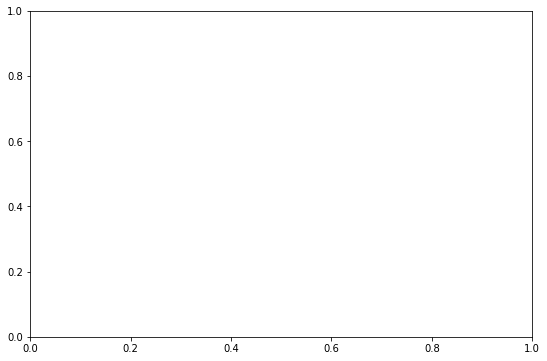

In [8]:
# all_accb_unc = []
# all_accsb_unc = []
# color=['orangered', 'y','lawngreen','b']
#
# fig1, ax1 = plt.subplots()
# fig1.set_size_inches(9, 6)
# for i, exp in enumerate(['Edl', 'Ensm','Drp', 'Vanl']):
#     exec('all_accb_unc' + '= all_accb_unc'+ f'{exp}')
#     exec('all_accsb_unc' + '= all_accsb_unc'+ f'{exp}')
#     acc_b_stack = np.stack(all_accb_unc, axis=0)
#     acc_b_mean = np.nanmean(acc_b_stack, axis=0)*100.
#     acc_b_std = np.sqrt(np.nanvar(acc_b_stack, axis=0))*10.
#     # fig1.set_size_inches(18.5, 10.5)
#     x = 1-np.array(unc_thrList)
#     ax1.plot(x, acc_b_mean, c=color[i], marker='o')
#     plt.fill_between(x, acc_b_mean-acc_b_std, acc_b_mean+acc_b_std,
#                      alpha=0.5, edgecolor=color[i], facecolor=color[i])
#
# plt.xlabel('Confidence threshold')
# plt.ylabel('Balanced-accuracy on cores p(y|x)>threshold')
# plt.xlim(0, 1.)
# plt.ylim(75, 100)
# plt.legend(['Evidential', 'Ensemble', 'MC Dropout','Vanilla'])
# plt.show()

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Degrees of freedom <= 0 for slice.
  import sys


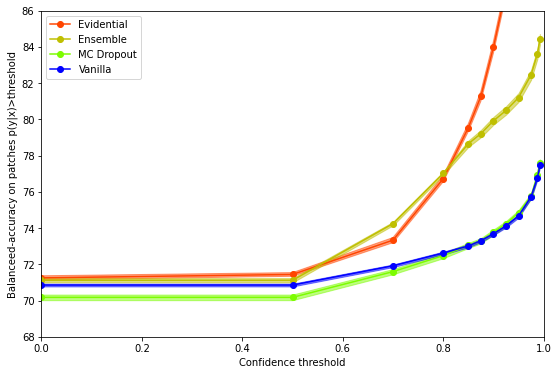

In [235]:
# fig1, ax1 = plt.subplots()
# fig1.set_size_inches(9, 6)
# for i, exp in enumerate(['Edl', 'Ensm','Drp', 'Vanl']):
#     exec('all_accsb_unc' + '= all_accsb_unc'+ f'{exp}')
#     acc_sb_stack = np.stack(all_accsb_unc, axis=0)
#     acc_sb_mean = np.nanmean(acc_sb_stack, axis=0)*100.
#     acc_sb_std = np.sqrt(np.nanvar(acc_sb_stack, axis=0))*10.
#     # fig1.set_size_inches(18.5, 10.5)
#     x = 1-np.array(unc_thrList)
#     ax1.plot(x, acc_sb_mean, c=color[i], marker='o')
#     plt.fill_between(x, acc_sb_mean-acc_sb_std, acc_sb_mean+acc_sb_std,
#                      alpha=0.5, edgecolor=color[i], facecolor=color[i])
#
# plt.xlabel('Confidence threshold')
# plt.ylabel('Balanceed-accuracy on patches p(y|x)>threshold')
# plt.xlim(0, 1.)
# plt.ylim(68, 86)
# plt.legend(['Evidential', 'Ensemble', 'MC Dropout','Vanilla'])
# plt.show()



In [13]:
#############################################################################################

In [ ]:
#############################################################################################

In [6]:
unc_thrList = [1., 0.5, 0.3, 0.2, 0.15, 0.125, 0.1, 0.075, 0.05,0.025, 0.0125, 0.0075,]
srs_list = [26, 30, 57]
seed_list = [0,5,10]

exp_name = 'edl'
exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs','_vs.25_edl-thr.2crr_sd','_ep200']
all_accbEdl, all_accb_uncEdl, all_accsb_uncEdl, all_eceEdl, all_BSEdl, no_uncEdl = \
    test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

srs and seed: 26 0


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


no uncertain cores 4
no uncertain cores 21
no uncertain cores 43
no uncertain cores 49
no uncertain cores 62
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 74
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 76
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7919684002633312, 0.7758393680052666, 0.7718268525311812, 0.8559210526315789, 0.967741935483871, 0.8154761904761905, 1.0, 1.0, 1.0, nan, nan, nan] 0.11759992935124286 0.10155782672414752
srs and seed: 26 5


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\u

no uncertain cores 18
no uncertain cores 42
no uncertain cores 51
no uncertain cores 68
no uncertain cores 74
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7646477946017116, 0.7646477946017116, 0.7748518762343647, 0.8621794871794872, 0.9434523809523809, 1.0, 1.0, 1.0, 1.0, nan, nan, nan] 0.14774187087503254 0.10688949106765269
srs and seed: 26 10


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib

no uncertain cores 2
no uncertain cores 21
no uncertain cores 38
no uncertain cores 52
no uncertain cores 64
no uncertain cores 74
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7919684002633312, 0.7919684002633312, 0.8142153413089375, 0.8434210526315788, 0.8737373737373737, 1.0, 1.0, 1.0, 1.0, nan, nan, nan] 0.12071960059623432 0.1000398597825966
srs and seed: 30 0


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
c:\users\mahdi\anaconda3

no uncertain cores 1
no uncertain cores 12
no uncertain cores 30
no uncertain cores 38
no uncertain cores 50
no uncertain cores 61
no uncertain cores 75
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7613561553653719, 0.7613561553653719, 0.7554421768707482, 0.7973484848484849, 0.896049896049896, 0.884375, 0.8557692307692308, 0.9473684210526315, 1.0, nan, nan, nan] 0.16145367923582724 0.11016952210342103
srs and seed: 30 5


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\Mahdi\Desktop\Summer21\RA\Codes\Minh_Mahdi_mod\prostate_cancer_classification\utils\metrics.py:16: RuntimeWarning: invalid value encountered in longlong_scalars
  return tp / (tp + fn)  # sensitivity
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: Runti

no uncertain cores 7
no uncertain cores 24
no uncertain cores 39
no uncertain cores 51
no uncertain cores 64
no uncertain cores 77
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7468729427254772, 0.7468729427254772, 0.7468729427254772, 0.759796238244514, 0.7952380952380953, 0.9066091954022988, 0.9136904761904762, 0.9666666666666667, 1.0, nan, nan, nan] 0.15736591302261732 0.1067554441272703
srs and seed: 30 10


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\an

no uncertain cores 7
no uncertain cores 37
no uncertain cores 65
no uncertain cores 72
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7962475312705728, 0.7962475312705728, 0.8281746031746031, 0.9285714285714286, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan] 0.09668175322123063 0.09996152263760906
srs and seed: 57 0


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\an

no uncertain cores 6
no uncertain cores 21
no uncertain cores 34
no uncertain cores 46
no uncertain cores 62
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 76
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7876892692560895, 0.7876892692560895, 0.771560236998025, 0.7942528735632184, 0.7907894736842105, 0.8198198198198199, 1.0, 1.0, 1.0, nan, nan, nan] 0.17928121200738814 0.11320704272669604
srs and seed: 57 5


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib

no uncertain cores 5
no uncertain cores 26
no uncertain cores 43
no uncertain cores 57
no uncertain cores 68
no uncertain cores 77
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7791310072416063, 0.7791310072416063, 0.7791310072416063, 0.7687406296851574, 0.8398496240601503, 0.8629629629629629, 0.7236842105263157, 0.9545454545454546, 1.0, nan, nan, nan] 0.1496328062820978 0.10818931383964343
srs and seed: 57 10


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\an

no uncertain cores 12
no uncertain cores 43
no uncertain cores 62
no uncertain cores 72
no uncertain cores 77
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7817643186306781, 0.8080974325213957, 0.8083720930232559, 0.9838709677419355, 0.9705882352941176, 1.0, 1.0, 1.0, nan, nan, nan, nan] 0.1109477324130019 0.10638580974350628


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\user

In [ ]:
exp_name = 'edl'
exp_suffix = ['_mskedPatch/1e-4_fr.0_crrt-ds-splt--_res10_srs','_vs.25_edl-thr.2crr_sd','_ep200']
all_accbEdl2, all_accb_uncEdl2, all_accsb_uncEdl2, all_eceEdl2, all_BSEdl2, no_uncEdl2 = \
    test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

In [7]:
srs_list = [26, 30, 57]
seed_list = [0,5,10]

exp_name = 'vanilla'
exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs','_vs.25_ce_sd','_ep200']
all_accbVanl, all_accb_uncVanl, all_accsb_uncVanl, all_eceVanl, all_BSVanl, no_uncVanl = \
    test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

srs and seed: 26 0
no uncertain cores 1
no uncertain cores 1
no uncertain cores 3
no uncertain cores 4
no uncertain cores 8
no uncertain cores 15
no uncertain cores 23
no uncertain cores 27
[0.8113890717577353, 0.8113890717577353, 0.8275181040158, 0.8275181040158, 0.8248299319727892, 0.8248299319727892, 0.8367346938775511, 0.86281179138322, 0.8444816053511706, 0.894927536231884, 0.9209459459459459, 0.903250773993808] 0.2348609353359948 0.13267032373325097
srs and seed: 26 5
no uncertain cores 4
no uncertain cores 6
no uncertain cores 9
no uncertain cores 10
[0.8505595786701777, 0.8505595786701777, 0.8505595786701777, 0.8344305464121132, 0.8080974325213957, 0.7919684002633312, 0.7919684002633312, 0.7919684002633312, 0.8333333333333333, 0.8392857142857143, 0.8653846153846154, 0.88] 0.209539223982398 0.1253971632389601
srs and seed: 26 10
no uncertain cores 2
no uncertain cores 2
no uncertain cores 4
no uncertain cores 5
no uncertain cores 5
no uncertain cores 12
no uncertain cores 18
no 

In [ ]:
exp_name = 'vanilla'
exp_suffix = ['_mskedPatch/1e-4_fr.0_crrt-ds-splt--_res10_srs','_vs.25_ce_sd','_ep200']
all_accbVanl2, all_accb_uncVanl2, all_accsb_uncVanl2, all_eceVanl2, all_BSVanl2, no_uncVanl2 =\
    test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

In [8]:
srs_list = [26, 30, 57]
seed_list = [0,5, 10]

exp_name = 'dropout'
exp_suffix = ['_mskedPatch/crrt-ds-splt--_res10_srs','_vs.25_ce-thr.1-drp.1-30_sd','_invl1val15tst_ep200']
all_accbDrp, all_accb_uncDrp, all_accsb_uncDrp, all_eceDrp, all_BSDrp, no_uncDrp = \
    test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

srs and seed: 26 0
no uncertain cores 1
no uncertain cores 2
no uncertain cores 2
no uncertain cores 3
no uncertain cores 4
no uncertain cores 14
no uncertain cores 21
no uncertain cores 27
no uncertain cores 35
[0.7495062541145491, 0.7495062541145491, 0.7656352863726136, 0.7809139784946236, 0.78125, 0.78125, 0.7823275862068966, 0.7767857142857143, 0.7896865520728008, 0.8322368421052632, 0.8834459459459459, 0.8963133640552995] 0.20931918781112746 0.12468424957362335
srs and seed: 26 5
no uncertain cores 1
no uncertain cores 2
no uncertain cores 2
no uncertain cores 6
no uncertain cores 12
no uncertain cores 14
no uncertain cores 22
no uncertain cores 31
no uncertain cores 34
[0.7893350888742594, 0.7893350888742594, 0.7732060566161949, 0.771505376344086, 0.769732326698696, 0.7858613589567605, 0.7904214559386973, 0.7509157509157509, 0.851219512195122, 0.8559006211180125, 0.887719298245614, 0.9208333333333334] 0.2400442797191802 0.1333530784672142
srs and seed: 26 10
no uncertain cores 1


In [ ]:
exp_name = 'dropout'
exp_suffix = ['_mskedPatch/fr.0--_res10_srs','_vs.25_ce-thr.1-drp.1-30_sd','_invl1val15tst_ep200']
all_accbDrp2, all_accb_uncDrp2, all_accsb_uncDrp2, all_eceDrp2, all_BSDrp2, no_uncDrp2 = \
    test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)


In [9]:
# unc_thrList = [1., 0.5, 0.3, 0.2, 0.15, 0.125, 0.1, 0.075, 0.05,0.025, 0.0125, 0.0075]
srs_list = [26,30,57,13,77]
seed_list = [0,5,10,15,20]

exp_name = 'ensm'
exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs','_vs.25_ce_sd','_ep200']
all_accbEnsm, all_accb_uncEnsm, all_accsb_uncEnsm, all_eceEnsm, all_BSEnsm, no_uncEnsm =\
    test_uncertainty_ensemble(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

srs and seed: 26 0
srs and seed: 26 5
srs and seed: 26 10
srs and seed: 26 15
srs and seed: 26 20
no uncertain cores 3
no uncertain cores 16
no uncertain cores 31
no uncertain cores 33
no uncertain cores 35
no uncertain cores 41
no uncertain cores 45
no uncertain cores 48
no uncertain cores 55
no uncertain cores 58
[0.8242264647794602, 0.8242264647794602, 0.8308189655172413, 0.827922077922078, 0.9186274509803922, 0.9134199134199135, 0.9074519230769231, 0.9090909090909092, 0.9444444444444444, 0.9444444444444444, 0.9166666666666667, 1.0] 0.16278373021260967 0.10738861866486378
srs and seed: 30 0
srs and seed: 30 5
srs and seed: 30 10
srs and seed: 30 15
srs and seed: 30 20
no uncertain cores 2
no uncertain cores 11
no uncertain cores 16
no uncertain cores 21
no uncertain cores 26
no uncertain cores 29
no uncertain cores 32
no uncertain cores 43
no uncertain cores 48
no uncertain cores 53
[0.7468729427254772, 0.7468729427254772, 0.7536032944406315, 0.7804545454545455, 0.7990033222591362, 

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


srs and seed: 77 5
srs and seed: 77 10
srs and seed: 77 15
srs and seed: 77 20
no uncertain cores 2
no uncertain cores 13
no uncertain cores 24
no uncertain cores 31
no uncertain cores 32
no uncertain cores 36
no uncertain cores 44
no uncertain cores 49
no uncertain cores 50
no uncertain cores 53
[0.7978933508887426, 0.7978933508887426, 0.7958333333333334, 0.8571428571428572, 0.757602862254025, 0.7916666666666667, 0.7727272727272727, 0.8, 0.7946428571428572, 0.8333333333333333, 0.9, 0.875] 0.17268382832195683 0.11278253538995726


In [ ]:
exp_name = 'ensm'
exp_suffix = ['_mskedPatch/1e-4_fr.0_crrt-ds-splt--_res10_srs','_vs.25_ce_sd','_ep200']
all_accbEnsm2, all_accb_uncEnsm2, all_accsb_uncEnsm2, all_eceEnsm2, all_BSEnsm2, no_uncEnsm2 =\
    test_uncertainty_ensemble(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

In [26]:
srs_list = [26,30, 57]
seed_list = [0,5,10]
#
# exp_name = 'vanilla'
# exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_inv.4_res10_srs','_vs.25_ce_sd','_ep100']
# all_accbVanl_4, all_accb_uncVanl_4, all_accsb_uncVanl_4, all_eceVanl_4, all_BSVanl_4, no_uncVanl_4 = \
#     test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)
#

exp_name = 'vanilla'
exp_suffix = ['_mskedPatch/1e-4_fr.0_crrt-ds-splt--_inv.4_res10_srs','_vs.25_ce_sd','_ep100']
all_accbVanl2_4, all_accb_uncVanl2_4, all_accsb_uncVanl2_4, all_eceVanl2_4, all_BSVanl2_4, no_uncVanl2_4 =\
    test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

exp_name = 'edl'
exp_suffix = ['_mskedPatch/1e-4_fr.0_crrt-ds-splt--_inv.4_res10_srs','_vs.25_edl-thr.2crr_sd','_ep100']
all_accbEdl2_4, all_accb_uncEdl2_4, all_accsb_uncEdl2_4, all_eceEdl2_4, all_BSEdl2_4, no_uncEdl2_4 = \
    test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

srs_list = [26,30,57,13,77]
seed_list = [0,5,10,15,20]

exp_name = 'ensm'
exp_suffix = ['_mskedPatch/1e-4_fr.0_crrt-ds-splt--_inv.4_res10_srs','_vs.25_ce_sd','_ep100']
all_accbEnsm2_4, all_accb_uncEnsm2_4, all_accsb_uncEnsm2_4, all_eceEnsm2_4, all_BSEnsm2_4, no_uncEnsm2_4 =\
    test_uncertainty_ensemble(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

srs and seed: 26 0
no uncertain cores 24
no uncertain cores 55
no uncertain cores 65
no uncertain cores 70
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 73
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 76
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7290980908492429, 0.7290980908492429, 0.7226173541963016, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan] 0.13304621834530786 0.11299559329649661
srs and seed: 26 5


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\u

no uncertain cores 53
no uncertain cores 74
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 76
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.8640552995391705, 0.8640552995391705, 0.9565217391304348, 1.0, 1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan, nan] 0.02

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\m

no uncertain cores 40
no uncertain cores 71
no uncertain cores 77
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 77
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 77
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 77
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.8522053982883475, 0.8522053982883475, 0.9047619047619048, 1.0, 1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan, nan] 0.0451942356860536 0.09927269264503762
srs and seed: 30 0


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\u

no uncertain cores 39
no uncertain cores 66
no uncertain cores 76
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.8215931533903884, 0.8215931533903884, 0.9410919540229885, 0.9615384615384616, 1.0, 1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan] 0.05448539582667528 0.10122642625770678
srs and seed: 30 5


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\

no uncertain cores 37
no uncertain cores 61
no uncertain cores 67
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 74
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 77
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 77
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7978933508887426, 0.7978933508887426, 0.9007936507936507, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan] 0.04429377632433193 0.09195031060112847
srs and seed: 30 10


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\u

no uncertain cores 3
no uncertain cores 10
no uncertain cores 14
no uncertain cores 28
no uncertain cores 41
no uncertain cores 54
no uncertain cores 66
no uncertain cores 71
no uncertain cores 73
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.8512179065174457, 0.8512179065174457, 0.804476629361422, 0.7858156028368795, 0.7825904121110177, 0.793233082706767, 0.8013493253373314, 0.8409090909090908, 0.8666666666666667, 0.875, 0.9, 0.875, nan, nan] 0.25105300586023216 0.14646927923218817
srs and seed: 57 0


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users

no uncertain cores 1
no uncertain cores 2
no uncertain cores 7
no uncertain cores 14
no uncertain cores 21
no uncertain cores 30
no uncertain cores 53
no uncertain cores 65
no uncertain cores 68
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7662936142198815, 0.7662936142198815, 0.7399605003291638, 0.7526881720430108, 0.7666666666666666, 0.7737520128824477, 0.760576923076923, 0.7452380952380953, 0.825, 0.8322368421052632, 0.8055555555555556, 0.875, nan, nan] 0.2925390317993626 0.1625216122706052
srs and seed: 57 5


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users

no uncertain cores 48
no uncertain cores 72
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 76
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.8420013166556946, 0.8420013166556946, 0.9137931034482758, 1.0, 1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan, nan] 0.04

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c

no uncertain cores 40
no uncertain cores 67
no uncertain cores 74
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 75
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 77
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.847926267281106, 0.847926267281106, 0.9482758620689655, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan] 0.0626214577304332 0.10156889043302618
srs and seed: 26 0


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\u

no uncertain cores 69
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\ma

no uncertain cores 2
no uncertain cores 73
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.8377221856484529, 0.8071379547014413, 1.

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\ma

no uncertain cores 67
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7867017774851877, 0.7867017774851877, 0.9444444444444444, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] 0.07

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users

no uncertain cores 66
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7689269256089533, 0.7689269256089533, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] 0.02022009227223206

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users

no uncertain cores 71
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\ma

 30 10
no uncertain cores 73
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.8522053982883475, 0.8683344305464121, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] 0.0233114032

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users

no uncertain cores 33
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7495062541145491, 0.6866515837104072, 1

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\an

no uncertain cores 61
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 75
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\ma

no uncertain cores 71
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\ma

srs and seed: 26 5
srs and seed: 26 10
srs and seed: 26 15
srs and seed: 26 20
no uncertain cores 51
no uncertain cores 75
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 76
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7978933508887426, 0.7978933508887426, 

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\u

srs and seed: 30 5
srs and seed: 30 10
srs and seed: 30 15
srs and seed: 30 20
no uncertain cores 49
no uncertain cores 66
no uncertain cores 76
no uncertain cores 77
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 77
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.8317972350230414, 0.8317972350230414, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan] 0.038520070222707904 0.0966934682297231
srs and see

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fa

srs and seed: 57 5
srs and seed: 57 10
srs and seed: 57 15
srs and seed: 57 20
no uncertain cores 51
no uncertain cores 73
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.8011849901250823, 0.8011849901250823, 0.9583333333333333, 0.9166666666666667, 1.0, 1.0, 1.0, 1

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divi

srs and seed: 13 5
srs and seed: 13 10
srs and seed: 13 15
srs and seed: 13 20
no uncertain cores 51
no uncertain cores 72
no uncertain cores 75
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 75
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 76
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.8199473337722185, 0.8199473337722185, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan, n

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\u

srs and seed: 77 5
srs and seed: 77 10
srs and seed: 77 15
no uncertain cores 45
no uncertain cores 69
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 73
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 75
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 76
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 77
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.8522053982883475, 0.8522053982883475, 0.8888888888888888, 

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\u

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Degrees of freedom <= 0 for slice.


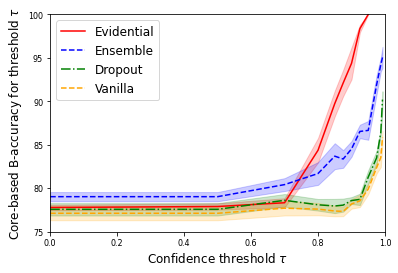

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: Degrees of freedom <= 0 for slice.


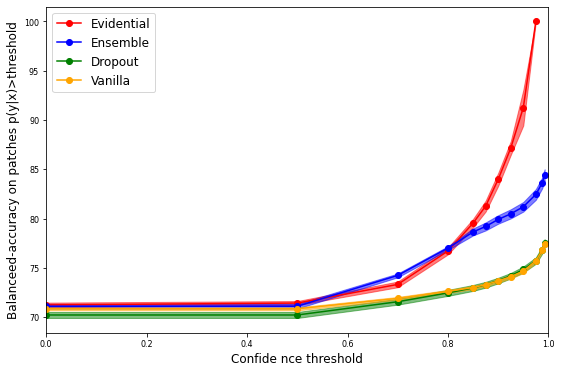

In [13]:
all_accb_unc = []
all_accsb_unc = []
color=['red', 'blue','green','orange']
ln_style = ['-', '--', '-.', '--']
# color=['orangered', 'y','g','lawngreen', 'b', 'cyan', 'r', 'brown']
# exp_names = ['Edl', 'Edl2', 'Vanl', 'Vanl2', 'Ensm', 'Ensm2', 'Drp', 'Drp2']
# exp_legends = ['Evidential + CoTeach', 'Evidential', 'Vanilla + CoTeach','Vanilla ', 'Ensemble + CoTeach', 'Ensemble',
#                'Dropout + CoTeach', 'Dropout']
exp_names = ['Edl', 'Ensm',  'Drp', 'Vanl']
# exp_legends = ['Evidential + CoTeach', 'Vanilla + CoTeach', 'Ensemble + CoTeach',
#                'Dropout + CoTeach']
exp_legends = ['Evidential', 'Ensemble',
               'Dropout', 'Vanilla']

# exp_names = ['Edl', 'Edl2', 'Vanl', 'Vanl2', 'Ensm', 'Ensm2', 'Vanl_4','Vanl2_4']
# exp_legends = ['Evidential + CoTeach', 'Evidential', 'Vanilla + CoTeach','Vanilla ', 'Ensemble + CoTeach', 'Ensemble',
#                'Vanilla0.4 + CoTeach', 'Vanilla0.4']
var_scale = 20.

fig1, ax1 = plt.subplots()
# fig1.set_size_inches(9, 6)
for i, exp in enumerate(exp_names):
    exec('all_accb_unc' + '= all_accb_unc'+ f'{exp}')
    acc_b_stack = np.stack(all_accb_unc, axis=0)
    acc_b_mean = np.nanmean(acc_b_stack, axis=0)*100.
    acc_b_std = np.sqrt(np.nanvar(acc_b_stack, axis=0))*var_scale
    # fig1.set_size_inches(18.5, 10.5)
    x = 1-np.array(unc_thrList)
    ax1.plot(x, acc_b_mean, c=color[i], linestyle=ln_style[i])
    plt.fill_between(x, acc_b_mean-acc_b_std, acc_b_mean+acc_b_std,
                     alpha=0.2, edgecolor=color[i], facecolor=color[i])

plt.rc('font', size=8)
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=12)
# plt.rc('xtick', labelsize=11)
# plt.rc('ytick', labelsize=11)
plt.rc('legend', fontsize=12)

plt.xlabel(r'Confidence threshold $\tau$')
plt.ylabel(r'Core-based B-accuracy for threshold $\tau$')
plt.xlim(0, 1.)
plt.ylim(75, 100)
plt.legend(exp_legends)
plt.show()

fig1, ax1 = plt.subplots()
fig1.set_size_inches(9, 6)
for i, exp in enumerate(exp_names):
    exec('all_accsb_unc' + '= all_accsb_unc'+ f'{exp}')
    acc_sb_stack = np.stack(all_accsb_unc, axis=0)
    acc_sb_mean = np.nanmean(acc_sb_stack, axis=0)*100.
    acc_sb_std = np.sqrt(np.nanvar(acc_sb_stack, axis=0))*var_scale
    # fig1.set_size_inches(18.5, 10.5)
    x = 1-np.array(unc_thrList)
    ax1.plot(x, acc_sb_mean, c=color[i], marker='o')
    plt.fill_between(x, acc_sb_mean-acc_sb_std, acc_sb_mean+acc_sb_std,
                     alpha=0.5, edgecolor=color[i], facecolor=color[i])

plt.xlabel('Confide nce threshold')
plt.ylabel('Balanceed-accuracy on patches p(y|x)>threshold')
plt.xlim(0, 1.)
# plt.ylim(65, 100)
plt.legend(exp_legends)
plt.show()

In [1]:
all_noCore_unc = []
all_noPatch_unc = []
color=['red', 'blue','green','orange']
ln_style = ['-', '--', '-.', '--']
# color=['orangered', 'y','g','lawngreen', 'b', 'cyan', 'r', 'brown']
# exp_names = ['Edl', 'Edl2', 'Vanl', 'Vanl2', 'Ensm', 'Ensm2', 'Drp', 'Drp2']
# exp_legends = ['Evidential + CoTeach', 'Evidential', 'Vanilla + CoTeach','Vanilla ', 'Ensemble + CoTeach', 'Ensemble',
#                'Dropout + CoTeach', 'Dropout']
exp_names = ['Edl', 'Ensm',  'Drp', 'Vanl']
# exp_legends = ['Evidential + CoTeach', 'Vanilla + CoTeach', 'Ensemble + CoTeach',
#                'Dropout + CoTeach']
exp_legends = ['Evidential', 'Ensemble',
               'Dropout', 'Vanilla']
var_scale = .2
no_testCore=80.
# no_testPatch=2808.

fig1, ax1 = plt.subplots()
# fig1.set_size_inches(9, 6)
for i, exp in enumerate(exp_names):
    exec('all_noCore_unc' + '= no_unc'+ f'{exp}'+'[0]')
    noCore_stack = np.stack(all_noCore_unc, axis=0)
    noCore_mean = np.nanmean(no_testCore-noCore_stack, axis=0)
    noCore_std = np.sqrt(np.var(no_testCore-noCore_stack, axis=0))*var_scale
    # fig1.set_size_inches(18.5, 10.5)
    x = 1-np.array(unc_thrList)
    ax1.plot(x, noCore_mean, c=color[i], linestyle=ln_style[i])
    plt.fill_between(x, noCore_mean-noCore_std, noCore_mean+noCore_std,
                     alpha=0.2, edgecolor=color[i], facecolor=color[i])
plt.rc('font', size=8)
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=12)
# plt.rc('xtick', labelsize=11)
# plt.rc('ytick', labelsize=11)
plt.rc('legend', fontsize=12)

plt.xlabel(r'Confidence threshold $\tau$')
plt.ylabel(r'Number of remaining cores')
plt.xlim(0, 1.)
# plt.ylim(75, 100)
plt.legend(exp_legends)
plt.show()

fig1, ax1 = plt.subplots()
fig1.set_size_inches(9, 6)
for i, exp in enumerate(exp_names):
    exec('all_noPatch_unc' + '= no_unc'+ f'{exp}'+'[1]')
    noPatch_stack = np.stack(all_noPatch_unc, axis=0)
    noPatch_mean = np.nanmean(noPatch_stack, axis=0)
    noPatch_std = np.sqrt(np.var(noPatch_stack, axis=0))*var_scale
    # fig1.set_size_inches(18.5, 10.5)
    x = 1-np.array(unc_thrList)
    ax1.plot(x, noPatch_mean, c=color[i], marker='o')
    plt.fill_between(x, noPatch_mean-noPatch_std, noPatch_mean+noPatch_std,
                     alpha=0.5, edgecolor=color[i], facecolor=color[i])

plt.xlabel('Confidence threshold')
plt.ylabel('Number of data points p(y|x)>threshold')
plt.xlim(0, 1.)
# plt.ylim(60, 100)
plt.legend(exp_legends)
plt.show()

NameError: name 'plt' is not defined

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


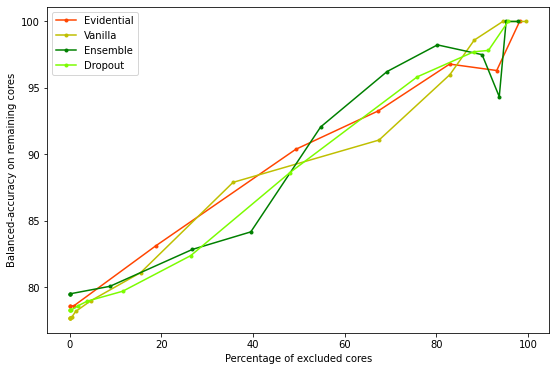

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


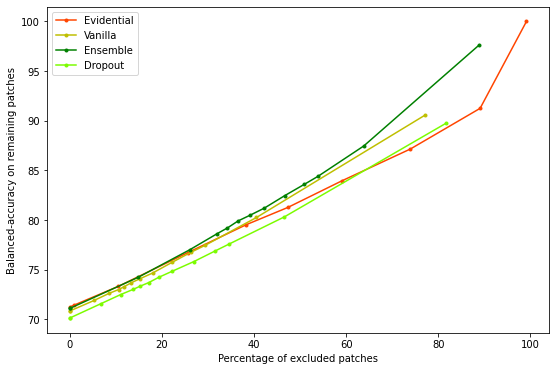

In [19]:
all_noCore_unc = []
all_noPatch_unc = []
color=['orangered', 'y','g','lawngreen', 'b', 'cyan', 'r', 'brown']
# exp_names = ['Edl', 'Edl2', 'Vanl', 'Vanl2', 'Ensm', 'Ensm2', 'Drp', 'Drp2']
# exp_legends = ['Evidential + CoTeach', 'Evidential', 'Vanilla + CoTeach','Vanilla ', 'Ensemble + CoTeach', 'Ensemble',
#                'Dropout + CoTeach', 'Dropout']
exp_names = ['Edl', 'Vanl', 'Ensm', 'Drp']
# exp_legends = ['Evidential + CoTeach', 'Vanilla + CoTeach', 'Ensemble + CoTeach',
#                'Dropout + CoTeach']
exp_legends = ['Evidential', 'Vanilla', 'Ensemble', 'Dropout']
var_scale = .1
no_testCore=80.

fig1, ax1 = plt.subplots()
fig1.set_size_inches(9, 6)
for i, exp in enumerate(exp_names):
    exec('all_noCore_unc' + '= no_unc'+ f'{exp}'+'[0]')
    noCore_stack = np.stack(all_noCore_unc, axis=0)
    noCore_mean = np.nanmean(noCore_stack*100./no_testCore, axis=0)
    exec('all_accb_unc' + '= all_accb_unc'+ f'{exp}')
    acc_b_stack = np.stack(all_accb_unc, axis=0)
    acc_b_mean = np.nanmean(acc_b_stack, axis=0)*100.
    ax1.plot(noCore_mean, acc_b_mean, c=color[i], marker='.')

plt.xlabel('Percentage of excluded cores')
plt.ylabel('Balanced-accuracy on remaining cores')
plt.legend(exp_legends)
plt.show()

fig1, ax1 = plt.subplots()
fig1.set_size_inches(9, 6)
for i, exp in enumerate(exp_names):
    exec('all_noPatch_unc' + '= no_unc'+ f'{exp}'+'[1]')
    noPatch_stack = np.stack(all_noPatch_unc, axis=0)
    noPatch_mean = np.nanmean(noPatch_stack*100./2808., axis=0)
    exec('all_accsb_unc' + '= all_accsb_unc'+ f'{exp}')
    acc_sb_stack = np.stack(all_accsb_unc, axis=0)
    acc_sb_mean = np.nanmean(acc_sb_stack, axis=0)*100.
    ax1.plot(100.-noPatch_mean, acc_sb_mean, c=color[i], marker='.')

plt.xlabel('Percentage of excluded patches')
plt.ylabel('Balanced-accuracy on remaining patches')
plt.legend(exp_legends)
plt.show()


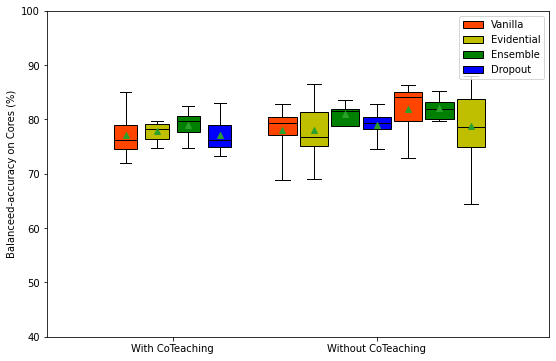

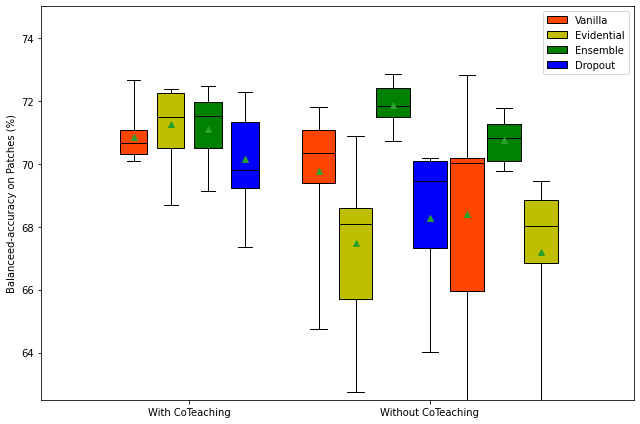

In [17]:
all_accb_unc = []
all_accsb_unc = []
clr=['orangered', 'y','g', 'b', 'orangered', 'g', 'y']

exp_names = ['Vanl', 'Edl', 'Ensm', 'Drp']
exp_names2 = ['Vanl2', 'Edl2', 'Ensm2', 'Drp2', 'Vanl2_4', 'Ensm2_4', 'Edl2_4']

exp_legends = ['Vanilla + CoTeach','Evidential + CoTeach', 'Ensemble + CoTeach']
exp_legends2 = ['Vanilla','Evidential', 'Ensemble', 'Dropout']

n_thr=0
pos_left = [0, 0.2, .4, 0.6]
pos_left = np.array(pos_left) - 0.4
pos_right = [1,1.2, 1.4, 1.6, 1.8, 2., 2.2]
pos_right = np.array(pos_right) - 0.4
acc_b_append = []
acc_b_append2 = []


fig1, ax1 = plt.subplots()
fig1.set_size_inches(9, 6)

for i, exp in enumerate(exp_names):
    exec('all_accb_unc' + '= all_accb_unc'+ f'{exp}')
    acc_b_stack = np.stack(all_accb_unc, axis=0)
    acc_b_append.append(acc_b_stack[:,n_thr]*100.)
for i, exp in enumerate(exp_names2):
    exec('all_accb_unc' + '= all_accb_unc'+ f'{exp}')
    acc_b_stack = np.stack(all_accb_unc, axis=0)
    acc_b_append2.append(acc_b_stack[:,n_thr]*100.)

bp = ax1.boxplot(acc_b_append, whis=100., patch_artist=True, positions=pos_left, showmeans=True)
bp2 = ax1.boxplot(acc_b_append2, whis=100., patch_artist=True, positions=pos_right, showmeans=True)
for bp_ in [bp, bp2]:
    for i, box in enumerate(bp_['boxes']):
        box.set(color='black')
        box.set(facecolor = clr[i], )
    for median in bp_['medians']:
        median.set(color='black')


# plt.xlabel('Confidence threshold')
plt.ylabel('Balanceed-accuracy on Cores (%)')
# plt.xlim(0, 1.)
plt.ylim(40, 100)
plt.xticks([np.mean(pos_left),np.mean(pos_right)], ['With CoTeaching', 'Without CoTeaching'])
ax1.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2], bp["boxes"][3]], exp_legends2, loc='upper right')
plt.show()
#% box plot patch
acc_sb_append = []
acc_sb_append2 = []

fig1, ax1 = plt.subplots()
fig1.set_size_inches(9, 6)

for i, exp in enumerate(exp_names):
    exec('all_accsb_unc' + '= all_accsb_unc'+ f'{exp}')
    acc_sb_stack = np.stack(all_accsb_unc, axis=0)
    acc_sb_append.append(acc_sb_stack[:,n_thr]*100.)
for i, exp in enumerate(exp_names2):
    exec('all_accsb_unc' + '= all_accsb_unc'+ f'{exp}')
    acc_sb_stack = np.stack(all_accsb_unc, axis=0)
    acc_sb_append2.append(acc_sb_stack[:,n_thr]*100.)

bp = ax1.boxplot(acc_sb_append, whis=100., patch_artist=True, positions=pos_left, showmeans=True)
bp2 = ax1.boxplot(acc_sb_append2, whis=100., patch_artist=True, positions=pos_right, showmeans=True)
for bp_ in [bp, bp2]:
    for i, box in enumerate(bp_['boxes']):
        box.set(color='black')
        box.set(facecolor = clr[i], )
    for median in bp_['medians']:
        median.set(color='black')
#
# for i, line in enumerate(bp['medians']):
#     x, y = line.get_xydata()[1]
#     text = ' μ={:.2f}\n σ={:.2f}'.format(np.array(acc_sb_append)[i].mean(), np.array(acc_sb_append)[i].std())
#     ax1.annotate(text, xy=(x, y))

# plt.xlabel('Confidence threshold')
plt.ylabel('Balanceed-accuracy on Patches (%)')
# plt.xlim(0, 1.)
plt.ylim(62.5, 75)
plt.xticks([np.mean(pos_left),np.mean(pos_right)], ['With CoTeaching', 'Without CoTeaching'])
ax1.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2], bp["boxes"][3]], exp_legends2, loc='upper right')
# plt.legend(exp_legends)
fig1.tight_layout()
plt.show()

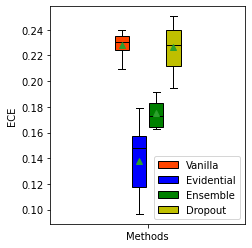

In [124]:
all_ece=[]
clr=['orangered', 'b','g', 'y', 'orangered', 'g', 'y']

exp_names = ['Vanl', 'Edl', 'Ensm', 'Drp',]
exp_names2 = ['Vanl2', 'Edl2', 'Ensm2', 'Drp2', 'Vanl2_4', 'Ensm2_4', 'Edl2_4']

exp_legends = ['Vanilla + CoTeach','Evidential + CoTeach', 'Ensemble + CoTeach']
exp_legends2 = ['Vanilla','Evidential', 'Ensemble', 'Dropout', ]#'Vanilla.4']

pos_left = [0, 0.12, .24, 0.36]
pos_right = [1,1.2, 1.4, 1.6, 1.8, 2., 2.2]
acc_b_append = []
acc_b_append2 = []

#% box plot patch
ece_append = []
ece_append2 = []

fig1, ax1 = plt.subplots()
# fig1.set_size_inches(9, 6)

for i, exp in enumerate(exp_names):
    exec('all_ece' + '= all_ece'+ f'{exp}')
    all_ece_stack = np.stack(all_ece, axis=0)
    ece_append.append(all_ece_stack)
# for i, exp in enumerate(exp_names2):
#     exec('all_ece' + '= all_ece'+ f'{exp}')
#     all_ece_stack = np.stack(all_ece, axis=0)
#     ece_append2.append(all_ece_stack)

bp = ax1.boxplot(ece_append, whis=100., patch_artist=True, positions=pos_left, showmeans=True, widths=(0.1))
# bp2 = ax1.boxplot(ece_append2, whis=100., patch_artist=True, positions=pos_right, showmeans=True)
for bp_ in [bp, ]:#bp2]:
    for i, box in enumerate(bp_['boxes']):
        box.set(color='black')
        box.set(facecolor = clr[i], )
    for median in bp_['medians']:
        median.set(color='black')


# plt.xlabel('Confidence threshold')
plt.ylabel('ECE')
# plt.xlim(0, 1.)
# plt.ylim(40, 100)
# plt.xticks([np.mean(pos_left),np.mean(pos_right)], ['With CoTeaching', 'Without CoTeaching'])
plt.xticks([np.mean(pos_left)], ['Methods'])
ax1.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2], bp["boxes"][3]], exp_legends2, loc='lower right')
# plt.legend(exp_legends)
plt.subplots_adjust(left=-0.1, right=0.35, )
plt.show()


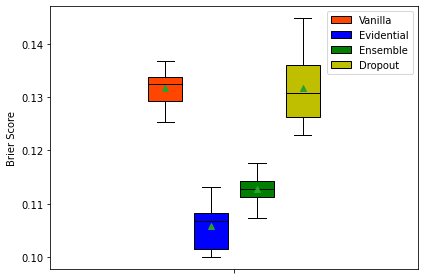

In [77]:
all_BS=[]
clr=['orangered', 'b','g', 'y', 'orangered', 'g', 'y']

exp_names = ['Vanl', 'Edl', 'Ensm', 'Drp',]# 'Vanl_4']
exp_names2 = ['Vanl2', 'Edl2', 'Ensm2', 'Drp2', 'Vanl2_4', 'Ensm2_4', 'Edl2_4']

exp_legends = ['Vanilla + CoTeach','Evidential + CoTeach', 'Ensemble + CoTeach']
exp_legends2 = ['Vanilla','Evidential', 'Ensemble', 'Dropout', ]#'Vanilla.4']

pos_left = [0, 0.2, .4, 0.6,]
pos_right = [1,1.2, 1.4, 1.6, 1.8, 2., 2.2]
BS_append = []
BS_append2 = []

fig1, ax1 = plt.subplots()
# fig1.set_size_inches(9, 6)

for i, exp in enumerate(exp_names):
    exec('all_BS' + '= all_BS'+ f'{exp}')
    all_BS_stack = np.stack(all_BS, axis=0)
    BS_append.append(all_BS_stack)
# for i, exp in enumerate(exp_names2):
#     exec('all_BS' + '= all_BS'+ f'{exp}')
#     all_BS_stack = np.stack(all_BS, axis=0)
#     BS_append2.append(all_BS_stack)

bp = ax1.boxplot(BS_append, whis=100., patch_artist=True, positions=pos_left, showmeans=True)
# bp2 = ax1.boxplot(BS_append2, whis=100., patch_artist=True, positions=pos_right, showmeans=True)
for bp_ in [bp,]:# bp2]:
    for i, box in enumerate(bp_['boxes']):
        box.set(color='black')
        box.set(facecolor = clr[i], )
    for median in bp_['medians']:
        median.set(color='black')

# for i, line in enumerate(bp['medians']):
#     x, y = line.get_xydata()[1]
#     text = ' μ={:.2f}\n σ={:.2f}'.format(np.array(BS_append)[i].mean(), np.array(BS_append)[i].std())
#     ax1.annotate(text, xy=(x, y))


# plt.xlabel('Confidence threshold')
plt.ylabel('Brier Score')
# plt.xlim(0, 1.)
# plt.ylim(.1, .25)
# plt.xticks([np.mean(pos_left),np.mean(pos_right)], ['With CoTeaching', 'Without CoTeaching'])
plt.xticks([np.mean(pos_left)], [''])
ax1.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2], bp["boxes"][3]], exp_legends2, loc='upper right')
# plt.legend(exp_legends)
fig1.tight_layout()
plt.show()

In [41]:
all_score=[]
exp_names = ['Vanl','Vanl2', 'Edl', 'Edl2', ]#'Ensm', 'Drp']
# , 'Ensm2', 'Drp2', 'Vanl2_4', 'Ensm2_4', 'Edl2_4']
for i, exp in enumerate(exp_names):
    exec('all_score' + '= no_unc'+ f'{exp}'+'[2]')
    acc_sb_stack = np.stack(all_score['acc_sb-unc'], axis=0)
    acc_sb_mean = np.mean(acc_sb_stack, axis=0)
    print('acc_sb'+exp, acc_sb_mean)

    acc_sb_stack = np.stack(all_score['auc'], axis=0)
    acc_sb_mean = np.mean(acc_sb_stack, axis=0)
    print('auc'+exp, acc_sb_mean)

    acc_sb_stack = np.stack(all_score['sen'], axis=0)
    acc_sen = np.mean(acc_sb_stack, axis=0)
    print('sen'+exp, acc_sen)

    acc_sb_stack = np.stack(all_score['spe'], axis=0)
    acc_spe = np.mean(acc_sb_stack, axis=0)
    print('spe'+exp, acc_spe)
    print('b_acc'+exp, 0.5*(acc_spe+acc_sen))

    exec('all_BS' + '= all_BS'+ f'{exp}')
    all_BS_stack = np.stack(all_BS, axis=0)
    acc_sb_mean = np.mean(all_BS_stack, axis=0)
    print('brier'+exp, acc_sb_mean,'\n')

    exec('all_BS' + '= all_ece'+ f'{exp}')
    all_BS_stack = np.stack(all_BS, axis=0)
    acc_sb_mean = np.mean(all_BS_stack, axis=0)
    print('ece'+exp, acc_sb_mean,'\n')

acc_sbVanl 0.7085559116809117
aucVanl 0.8767281105990783
senVanl 0.685483870967742
speVanl 0.8571428571428572
b_accVanl 0.7713133640552996
brierVanl 0.13177034725830425 

eceVanl 0.2282978517488919 

acc_sbVanl2 0.6977287116176005
aucVanl2 0.8996781508302245
senVanl2 0.7132616487455198
speVanl2 0.8480725623582767
b_accVanl2 0.7806671055518982
brierVanl2 0.10767686559490555 

eceVanl2 0.10690884133632819 

acc_sbEdl 0.7125276986388097
aucEdl 0.8776607417160411
senEdl 0.6738351254480288
speEdl 0.8820861678004536
b_accEdl 0.7779606466242412
brierEdl 0.10590620363917144 

eceEdl 0.1379360552227414 

acc_sbEdl2 0.674738841405508
aucEdl2 0.8827810694170143
senEdl2 0.7132616487455198
speEdl2 0.8480725623582767
b_accEdl2 0.7806671055518982
brierEdl2 0.14255255964520083 

eceEdl2 0.1989192440028084 



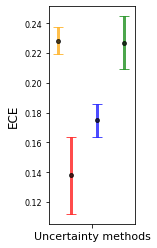

In [50]:
from matplotlib.transforms import Affine2D
all_ece=[]
clr=['orange', 'red','blue','green']

exp_names = ['Vanl', 'Edl', 'Ensm', 'Drp',]
exp_legends2 = ['Vanilla','Evidential', 'Ensemble', 'Dropout', ]#'Vanilla.4']

pos_left = [0, 1, 2, 3]
#% box plot patch
ece_append = []
ece_append_std = []

fig1, ax1 = plt.subplots()
# fig1.set_size_inches(9, 6)

for i, exp in enumerate(exp_names):
    exec('all_ece' + '= all_ece'+ f'{exp}')
    all_ece_stack = np.stack(all_ece, axis=0)
    ece_append.append(all_ece_stack.mean())
    ece_append_std.append(all_ece_stack.std())
stdd= np.array(ece_append_std).reshape(4,)
meann= np.array(ece_append).reshape(4,)

# print(np.repeat(ece_append_std,[1,2], axis=0))
trans1 = Affine2D().translate(-.3, 0.) +ax1.transData
trans3 = Affine2D().translate(-.3, 0.) +ax1.transData
trans2 = Affine2D().translate(.2, 0.) +ax1.transData
i=0
el = ax1.errorbar(x=np.array(pos_left).reshape(4,)[i], y=meann[i], yerr=stdd[i],fmt='o', elinewidth=3,markeredgecolor='black',
         markerfacecolor='black', capsize=5, markersize=4, c=clr[i], alpha=0.7, transform=trans2)
for i in range(1,3):
    el = ax1.errorbar(x=np.array(pos_left).reshape(4,)[i], y=meann[i], yerr=stdd[i],fmt='o', elinewidth=3,markeredgecolor='black',
             markerfacecolor='black', capsize=5, markersize=4, c=clr[i], alpha=0.7, transform=trans1)
i=3
el = ax1.errorbar(x=np.array(pos_left).reshape(4,)[i], y=meann[i], yerr=stdd[i],fmt='o', elinewidth=3,markeredgecolor='black',
             markerfacecolor='black', capsize=5, markersize=4, c=clr[i], alpha=0.7,transform=trans3)
# elines = el.get_children()
# elines[0].set_color('black')

# plt.xlabel('Confidence threshold')

plt.rc('font', size=8)
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=11)
# plt.rc('ytick', labelsize=11)
plt.rc('legend', fontsize=12)
plt.ylabel('ECE')
# plt.xlim(0, 1.)
# plt.ylim(40, 100)
# plt.xticks([np.mean(pos_left),np.mean(pos_right)], ['With CoTeaching', 'Without CoTeaching'])
plt.xticks([np.mean(pos_left)], ['Uncertainty methods'])
# ax1.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2], bp["boxes"][3]], exp_legends2, loc='lower right')
# plt.legend(exp_legends)
plt.subplots_adjust(left=0.1, right=0.3, )
# fig1.tight_layout()
plt.show()